# Propensity Model - Bank Marketing Data # 
[Original dataset from UCI Archive](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing)

This version of the notebook goes through the basic steps of data clean-up and EDA. Predictive Power Score (PPS) is used for feature selection. PPS basically does a 1 variable Decision Tree model for each feature in the dataset, automatically making that a classifier or regressor depending on variable type. For classification it is based on the F1 score, for regression it is based on Mean Absolute Error (MAE)

If the variable is categorical, the PPS is determined by:
`PPS = (F1_model - F1_naive)/(1 - F1_naive)`
where _F1_naive_ is the "F1 score for a model that always predicts the most common class of the target column (_F1_most_common_) and a model that predicts random values (_F1_random_)". So if 90% of a dataset results in a "True" classification, F1_most_common will probably be used. If the dataset is more balanced and only 51% is a "True" classification, then the _F1_random_ might be chosen (unless we have a very large dataset such that we can assume "random" will result in 50% accuracy). This all assumes a binary classification. Multiple classes would extend things a bit.

If the variable is continuous, the PPS is determined by:
`PPS = (MAE_model / MAE_naive)`
where _MAE_naive_ "always predicts the median of the target column."

This dataset is quite imbalanced, with just over 11% of the target column = "yes" vs "no". Such a large imbalance can lead to issues in model training and mislead model evaluation. The accuracy can look quite good until you realize that simply assuming "no" 100% of the time will result in > 90% accuracy. This notebook tries to compensate for that by using shuffled K-Fold validation instead of stratified. The SVC model is also directed to use a balanced training. But in the end, this doesn't seem to be the most direct method. Each operation (splits, model training, evaluation) often require dealing with the imbalance differently. The more traditional method of dealing with imbalance is either undersampling the majority classification or using oversampling on the minority classification. Scikit-Learn doesn't support this. In the next version of this notebook, we'll incorporate the imbalanced-learn library that will give us that capability.

Three models are trained and evaluated: KNN, Support Vector Classifier, and RandomForest. There is currently no tuning of hyperparameters. Of the 3, Random Forest shows the best model evaluation numbers, but there's concern that the model may be overtrained. The number of splits in the tree were limited to help with that, but without better control of the train/test split process, it's hard to trust the evaluation numbers completely.

In [218]:
import sys
import time
import numpy as np
import pandas as pd
import sklearn.base
import ppscore as pps
import seaborn as sns
import yellowbrick.base
import matplotlib

from yellowbrick.target.feature_correlation import feature_correlation
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score

# https://github.com/scikit-learn-contrib/imbalanced-learn

print("Python version: {}.{}.{}".format(sys.version_info[0], sys.version_info[1], sys.version_info[2]))
pythonVersion = str(sys.version_info[0])+"."+str(sys.version_info[1])
print("NumPy version: ",np.__version__)
print("Pandas version: ",pd.__version__)
print("SK Learn version: ",sklearn.__version__)
print("Yellowbrick version: ",yellowbrick.__version__)

global gl_rev_per_encounter
global gl_cost_per_encounter
gl_rev_per_encounter = 80
gl_cost_per_encounter = 30

Python version: 3.7.1
NumPy version:  1.19.2
Pandas version:  1.2.1
SK Learn version:  0.22.1
Yellowbrick version:  1.1


In [166]:
df = pd.read_csv('./bank-additional/bank-additional/bank-additional-full.csv', sep=';', header=0)

## Let's look at the data 

In [167]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Balanced data sample?

In [51]:
df['y'].value_counts()

no     36537
yes     4639
Name: y, dtype: int64

No, not very balanced. Might need to balance that when fitting the model

### Let's check for duplicates: 
`dataframe.duplicated(keep=False)` will return a boolean Series of True = Duplicate for all rows that are duplicates (all copies). If `keep = 'first'` or `keep = 'last'`, only the the first or last of each group of duplicates will be flagged. `.value_counts` on the resulting Series will tell us how many duplicates were found (the True values). Remember that with keep false we're counting all duplicate instances.

In [169]:
sdups = df.duplicated(keep=False)
sdups.value_counts()

False    41164
True        24
dtype: int64

Now, it would be good to see what the dups look like before we drop them. With `sdups` we have a simple mask that can be used as an index mask on the main dataframe

In [170]:
df[sdups]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
1265,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
1266,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
12260,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
12261,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
14155,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
14234,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
16819,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,...,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
16956,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,...,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
18464,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no
18465,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no


Those look like pretty ordinary duplicates, so let's just pick 1 of each pair and delete it. Double check the new row count is correct and double check for dups.

In [171]:
df.drop_duplicates(keep='first', inplace=True)
df.shape

(41176, 21)

In [172]:
sdups = df.duplicated(keep=False)
sdups.value_counts()

False    41176
dtype: int64

### Check for na

In [173]:
for col in df.columns:
    print(col+":")
    print(df[col].isna().value_counts())
    if 'True' in df[col].isna().value_counts():
        print("*************")

age:
False    41176
Name: age, dtype: int64
job:
False    41176
Name: job, dtype: int64
marital:
False    41176
Name: marital, dtype: int64
education:
False    41176
Name: education, dtype: int64
default:
False    41176
Name: default, dtype: int64
housing:
False    41176
Name: housing, dtype: int64
loan:
False    41176
Name: loan, dtype: int64
contact:
False    41176
Name: contact, dtype: int64
month:
False    41176
Name: month, dtype: int64
day_of_week:
False    41176
Name: day_of_week, dtype: int64
duration:
False    41176
Name: duration, dtype: int64
campaign:
False    41176
Name: campaign, dtype: int64
pdays:
False    41176
Name: pdays, dtype: int64
previous:
False    41176
Name: previous, dtype: int64
poutcome:
False    41176
Name: poutcome, dtype: int64
emp.var.rate:
False    41176
Name: emp.var.rate, dtype: int64
cons.price.idx:
False    41176
Name: cons.price.idx, dtype: int64
cons.conf.idx:
False    41176
Name: cons.conf.idx, dtype: int64
euribor3m:
False    41176
Name: euribo

### Reset the index 

Now that we've dropped duplicate rows, let's reset the index. Some code in pandas and/or yellowbrick seems to rely on numerical values of the row key, so if one is missing, that causes problems.

In [174]:
df.reset_index(drop=True, inplace=True)

__Do some organizational stuff for later on__

In [175]:
xCols = list(df.columns)
xCols.remove('y')
yData = df['y']
yDataInt = yData.transform(lambda x: 1 if x=='yes'else 0)
numCols = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m','nr.employed']
catCols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

#### Get some idea of the numerical features

Note that 'campaign' is really an ordinal/categorical value representing the marketing campaign # of the contact. It shouldn't be treated as a numerical value. in the model.

In [176]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41176.00000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000
mean,40.02380,258.315815,2.567879,962.464810,0.173013,0.081922,93.575720,-40.502863,3.621293,5167.034870
std,10.42068,259.305321,2.770318,186.937102,0.494964,1.570883,0.578839,4.627860,1.734437,72.251364
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


#### And get some idea of the categorical features

In [177]:
for col in catCols:
    print(df[col].value_counts())

admin.           10419
blue-collar       9253
technician        6739
services          3967
management        2924
retired           1718
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64
married     24921
single      11564
divorced     4611
unknown        80
Name: marital, dtype: int64
university.degree      12164
high.school             9512
basic.9y                6045
professional.course     5240
basic.4y                4176
basic.6y                2291
unknown                 1730
illiterate                18
Name: education, dtype: int64
no         32577
unknown     8596
yes            3
Name: default, dtype: int64
yes        21571
no         18615
unknown      990
Name: housing, dtype: int64
no         33938
yes         6248
unknown      990
Name: loan, dtype: int64
cellular     26135
telephone    15041
Name: contact, dtype: int64
may    13767
jul     7169
aug     6176

### Start looking for features with good predictive capability

#### Rank2D

In [180]:
from yellowbrick.features import rank2d

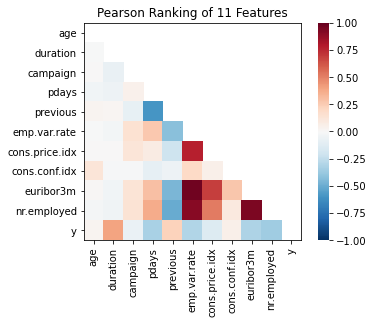

C:\Users\wadeb\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


Rank2D(algorithm=None,
       ax=<AxesSubplot:title={'center':'Pearson Ranking of 11 Features'}>,
       colormap='RdBu_r', features=None, show_feature_names=None)

In [181]:
rank2d(df[numCols].join(yDataInt))

#### Predictive Power Score 

*Experimenting with the sample option here. Normally pps would take a random sample of 5K rows. Since this dataset is heavily weighted towards the 'n' case, we might not end up with a strong enough sample of 'y' data points. To work around that for now, we'll turn off sampling. This will have to be considered in the model, we may want to oversample the 'y' points. Note that it does make a difference in the score values and could potentially lead to somebody including or not including a feature.*

In [182]:
ppsMatrixFull= pps.matrix(df, sample=None)

C:\Users\wadeb\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\wadeb\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\wadeb\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\wadeb\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\wadeb\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least

In [183]:
ppsMatrix = pps.matrix(df)

C:\Users\wadeb\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\wadeb\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\wadeb\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\wadeb\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\wadeb\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least

In [184]:
print(ppsMatrixFull[ppsMatrix['x']=='y'])

     x               y       ppscore            case  is_valid_score  \
420  y             age  0.000000e+00      regression            True   
421  y             job  0.000000e+00  classification            True   
422  y         marital  0.000000e+00  classification            True   
423  y       education  0.000000e+00  classification            True   
424  y         default  2.045336e-09  classification            True   
425  y         housing  0.000000e+00  classification            True   
426  y            loan  3.045680e-09  classification            True   
427  y         contact  0.000000e+00  classification            True   
428  y           month  0.000000e+00  classification            True   
429  y     day_of_week  0.000000e+00  classification            True   
430  y        duration  1.025890e-02      regression            True   
431  y        campaign  0.000000e+00      regression            True   
432  y           pdays  0.000000e+00      regression            

In [185]:
print(ppsMatrix[ppsMatrix['x']=='y'])

     x               y       ppscore            case  is_valid_score  \
420  y             age  0.000000e+00      regression            True   
421  y             job  0.000000e+00  classification            True   
422  y         marital  0.000000e+00  classification            True   
423  y       education  0.000000e+00  classification            True   
424  y         default  0.000000e+00  classification            True   
425  y         housing  0.000000e+00  classification            True   
426  y            loan  1.561424e-07  classification            True   
427  y         contact  0.000000e+00  classification            True   
428  y           month  0.000000e+00  classification            True   
429  y     day_of_week  0.000000e+00  classification            True   
430  y        duration  1.336501e-02      regression            True   
431  y        campaign  0.000000e+00      regression            True   
432  y           pdays  0.000000e+00      regression            

In [186]:
tempDF=ppsMatrixFull[['x', 'y', 'ppscore', 'baseline_score', 'model_score']]
print(tempDF[(tempDF['x']=='y') & (tempDF['ppscore']!=0)])
print(tempDF[(tempDF['y']=='y') & (tempDF['ppscore']>3.1780485e-09)])
features2UseDF = tempDF[(tempDF['y']=='y')].drop(columns=["y", "baseline_score", "model_score"])
#features2UseDF.drop(columns=["y", "baseline_score", "model_score"], inplace=True)

     x               y       ppscore  baseline_score  model_score
424  y         default  2.045336e-09        0.698921     0.698921
426  y            loan  3.045680e-09        0.744796     0.744796
430  y        duration  1.025890e-02      157.445065   155.829852
434  y        poutcome  2.736134e-09        0.800094     0.800094
436  y  cons.price.idx  8.491926e-03        0.509059     0.504736
440  y               y  1.000000e+00        0.000000     1.000000
                  x  y   ppscore  baseline_score  model_score
20              age  y  0.025809        0.834369     0.838643
188           month  y  0.052276        0.834369     0.843027
230        duration  y  0.160887        0.834369     0.861016
272           pdays  y  0.227693        0.834369     0.872082
293        previous  y  0.047017        0.834369     0.842156
314        poutcome  y  0.225608        0.834369     0.871736
335    emp.var.rate  y  0.118174        0.834369     0.853942
356  cons.price.idx  y  0.180819        0.

**Let's focus on these:**
---
The following is a sorted list of all the Predictive Power Scores. It's easy to see where big changes in magnitude of the PPS changes as we go from e-01 to e-02 to e-09. We might choose to focus on the 8 features in the e-01 range, or we could add the extra 3 features that drop into the e-02 range. Anything in the e-09 range is practically 0 so it's probably not worth bothering with those. The feature reduction will help once we start encoding the categorical features.

In [187]:
features2UseDF.sort_values('ppscore', ascending=False).reset_index().loc[1:]

,index,x,ppscore
1,272,pdays,2.276925e-01
2,314,poutcome,2.256076e-01
3,398,euribor3m,2.027842e-01
4,419,nr.employed,1.895143e-01
5,377,cons.conf.idx,1.808194e-01
6,356,cons.price.idx,1.808194e-01
7,230,duration,1.608868e-01
8,335,emp.var.rate,1.181736e-01
9,188,month,5.227629e-02
10,293,previous,4.701668e-02


Maybe there's another question to answer- Do we include the e-02 columns or not? Including the age and previous columns is relatively minor since they're numeric. Including month will add 11 columns for OneHot encoding, so maybe we want to think about that first. Maybe a stacked bar-graph showing the # (or %) of contacts in each month that were successful or not.

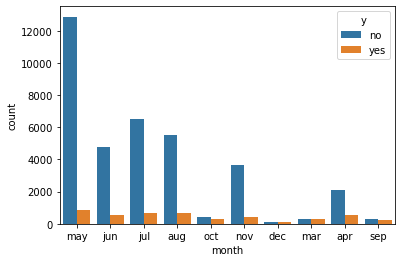

In [188]:
#perMonthSuccess = sn.load_dataset(df['month', 'y'])
ax = sns.countplot(x='month', hue='y' , data = df[['month', 'y']])

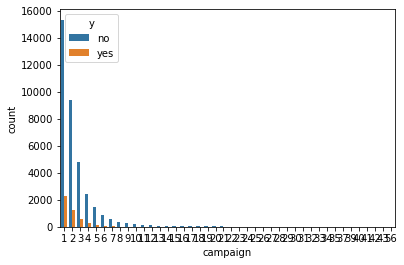

In [189]:
ax = sns.countplot(x='campaign', hue='y' , data = df[['campaign', 'y']])

Seems like Oct, Dec, Mar, and Sep are about 50/50 for success, other months, especially May, are very low percentage. So maybe it's worth keeping the Month column and encoding it.

In [190]:
df.drop(columns=['day_of_week', 'job', 'campaign', 'contact', 'loan', 'housing', 'default', 'education', 'marital'], inplace=True)

#### Normalize numerics, encode the categorics

Note that the instatiation and fitting of the normalizer and encoders here is really just kind of debug. They're only actually being used in the `Pipeline` call. Besides checking that `fit`, if you want to check the actual results, use something like `encTarget.transform(df['y'].loc[0:15])`

In [191]:
numericCols = ['pdays', 'euribor3m', 'nr.employed', 'cons.conf.idx', 'cons.price.idx', 'duration', 'emp.var.rate', 'previous', 'age']
catCols = ['month', 'poutcome']#, 'euribor3m', 'nr.employed', 'cons.conf.idx', 'cons.price.idx', 'duration', 'emp.var.rate', 'previous', 'age']

normalizer = MinMaxScaler()
normalizer.fit(df[numericCols])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [192]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df[catCols])

encTarget = LabelBinarizer()
encTarget.fit(df['y'].to_numpy().reshape(-1, 1)) # The reshape is needed with a Series

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

#### Setup the Pipeline

In [193]:
pipeNumeric = Pipeline([('normalizeNum', MinMaxScaler())])
pipeCategoric = Pipeline([('encodeCat', OneHotEncoder(handle_unknown='ignore'))])

fullPipe = ColumnTransformer([
    ("cont", pipeNumeric, numericCols),
    ("disc", pipeCategoric, catCols)],
    remainder = 'passthrough')

inputDF = df.drop(columns=['y'])
#targetDF = encTarget.transform(df['y']) # This wasn't really needed, the models can handled label data.
targetDF = df['y']

dataModelReady = fullPipe.fit_transform(inputDF)

#### How to do the cross-validation split:

In [194]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
#splits = StratifiedKFold(n_splits=5, shuffle = True)
splits = KFold(n_splits=5, shuffle = True, random_state = 42)
splits.get_n_splits(inputDF, targetDF)

5

In [195]:
scoringList = ['balanced_accuracy', 'roc_auc']

### Model Training and Scoring

**KNN**

In [196]:
knn = KNeighborsClassifier()
fullPipe_KNN = Pipeline([
                        ('dataPrep', fullPipe),
                        ('model', knn)])

scores = cross_val_score(fullPipe_KNN, inputDF, targetDF, scoring = 'balanced_accuracy', cv = splits)
print("KNN classifier score:", scores)

KNN classifier score: [0.70492691 0.71209286 0.71787869 0.71733239 0.72046059]


**SVC**

In [197]:
svc = LinearSVC(class_weight = 'balanced')
fullPipe_SVC = Pipeline([
                        ('dataPrep', fullPipe),
                        ('model', svc)])

#scores = cross_val_score(fullPipe_SVC, inputDF, targetDF, scoring = 'balanced_accuracy', cv = splits)
scores = cross_validate(fullPipe_SVC, inputDF, targetDF, scoring = scoringList, cv = splits)
print("SVC classifier score:", scores)

SVC classifier score: {'fit_time': array([2.51726651, 1.81916523, 2.27992845, 2.69878221, 2.17620802]), 'score_time': array([0.07180977, 0.09870434, 0.09172821, 0.07978415, 0.06878853]), 'test_balanced_accuracy': array([0.85584412, 0.85886282, 0.86853667, 0.86956906, 0.8657679 ]), 'test_roc_auc': array([0.9300392 , 0.93448357, 0.9415191 , 0.93638999, 0.93519178])}


C:\Users\wadeb\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


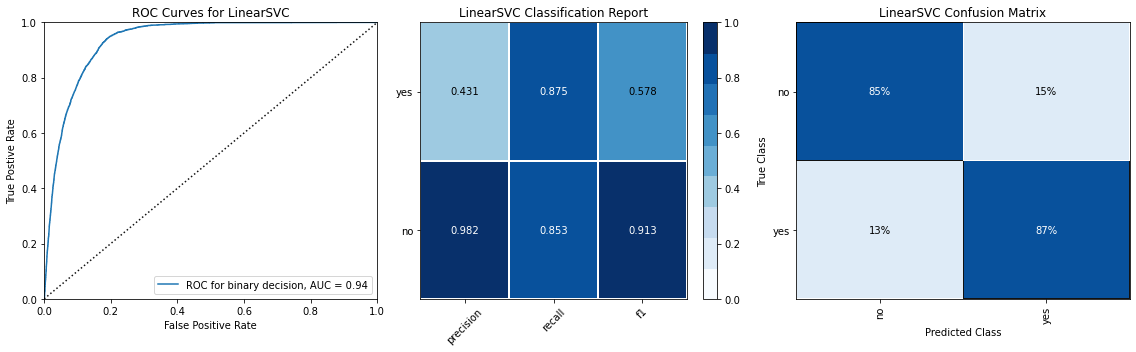

In [198]:
evaluate_model(fullPipe_SVC, ["no", "yes"], inputDF, targetDF.map({'no':0, 'yes':1}))

**RFC**

In [199]:
rfc = RandomForestClassifier(class_weight = 'balanced', min_samples_leaf = 10)
fullPipe_RFC = Pipeline([
                        ('dataPrep', fullPipe),
                        ('model', rfc)])

#scores = cross_val_score(fullPipe_SVC, inputDF, targetDF, scoring = 'balanced_accuracy', cv = splits)
scores = cross_validate(fullPipe_RFC, inputDF, targetDF, scoring = scoringList, cv = splits)
print("RFC classifier score:", scores)

RFC classifier score: {'fit_time': array([1.54486895, 1.43117332, 1.50395036, 1.50195527, 1.46508193]), 'score_time': array([0.18652749, 0.17752409, 0.19251132, 0.18453431, 0.18049073]), 'test_balanced_accuracy': array([0.88394564, 0.88097715, 0.88904711, 0.88700522, 0.88611751]), 'test_roc_auc': array([0.94422619, 0.94662917, 0.95083595, 0.94477326, 0.94750493])}


Remember, the `evaluate_model` function generates data by training and predicting on the entire dataset. The results in this data, then, imply that the model may be overtrained. Pruning the trees back a bit might help.

C:\Users\wadeb\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


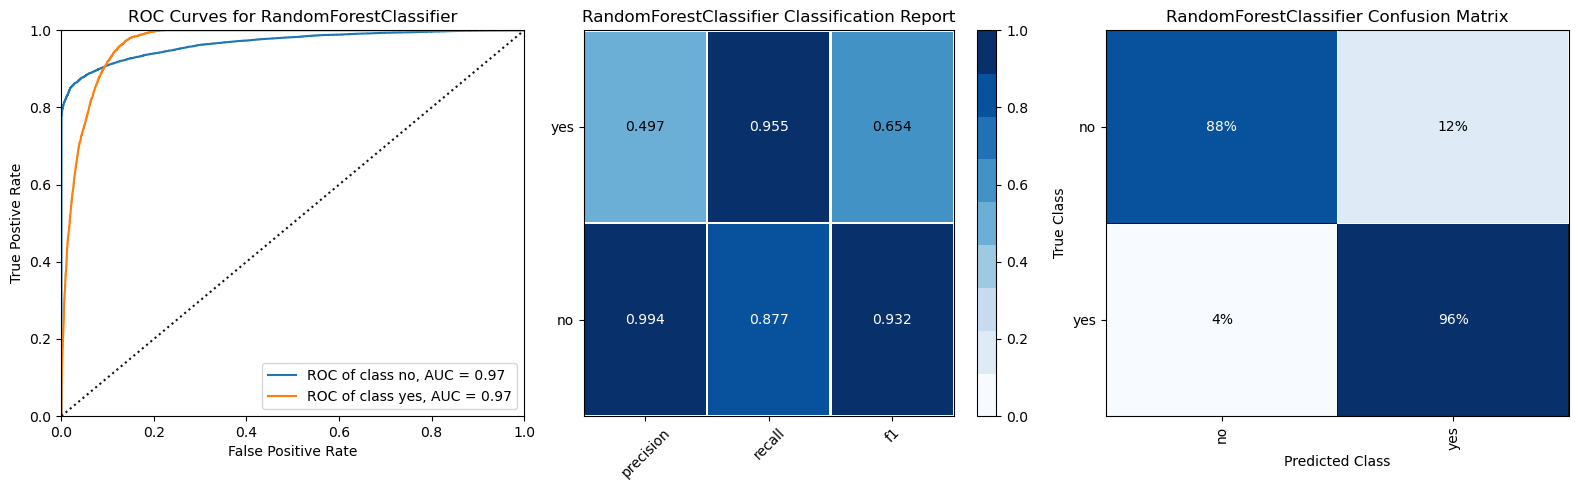

In [200]:
evaluate_model(fullPipe_RFC, ["no", "yes"], inputDF, targetDF)

### Model Eval Info

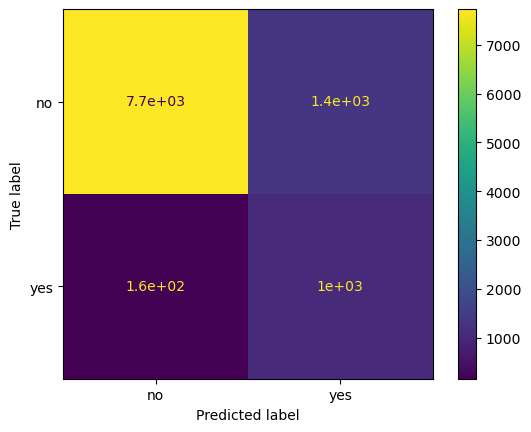

In [201]:
#cm = ConfusionMatrix(model, classes=['no', 'yes'])
X_train, X_test, y_train, y_test = train_test_split(inputDF, targetDF, random_state=42)
fullPipe_SVC.fit(X_train, y_train)
plot_confusion_matrix(fullPipe_SVC, X_test, y_test)

In [202]:
print(1400/(7700+1400))
print(160/(160+1000))

0.15384615384615385
0.13793103448275862


**precision_recall_curve** 

This function takes the array of Y data scores from the specified model, the estimated probabilities (or output of decision function) from the trained model and then returns 3 arrays. The first two are the values for the precision and the recall at specific threshold values. Those threshold values are in the third array. So if we use the first two arrays as Y values and the third as X, we get a nice plot of precision and recall across a range of threshold values.

Note that the SVC model supports the `.decision_function` method that returns a 1-D array of values representing confidence scores for each observation. Other models, like RandomForestClassifier, support the `.predict_proba` method that returns a 2-D array representing the probability of each classification for each observation. (actually, that assumes a binary classifier. An *n*-class model would probably return an *n*-D array.

In [204]:
from sklearn.metrics import precision_recall_curve

model_y_scores = fullPipe_SVC.decision_function(X_test)
precisions, recalls, thresholds = precision_recall_curve(y_test, model_y_scores, pos_label='yes')
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

ZeroDivisionError: float division by zero

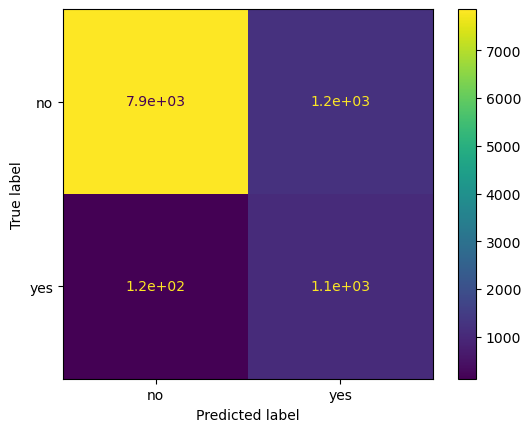

In [205]:
fullPipe_RFC.fit(X_train, y_train)
plot_confusion_matrix(fullPipe_RFC, X_test, y_test)

In [ ]:
print(1200/(7900+1200))
print(110/(110+1100))

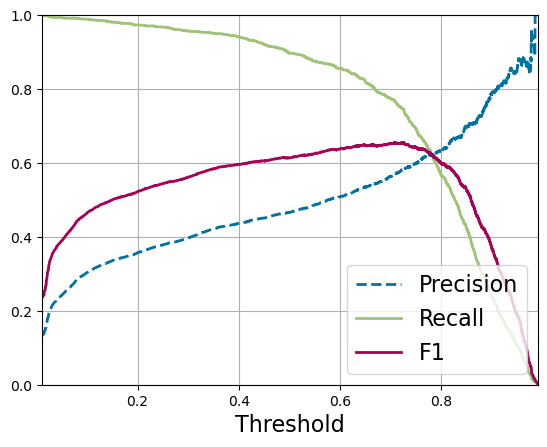

In [206]:
model_y_scores = fullPipe_RFC.predict_proba(X_test)
precisions, recalls, thresholds = precision_recall_curve(y_test, model_y_scores[:,1], pos_label='yes')
maxF1 = plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

#### Maximum F1
While we may be overfitting, the max F1 value, shown below, might be a better threshold than the default 0.5

In [207]:
print(maxF1)

0.6556534508076358


`model_y_scores` (which are actually the return of `.predict_proba(X)`) might look something like:
```
array([[0.11682319, 0.88317681],
       [0.93513411, 0.06486589],
       [0.1940993 , 0.8059007 ],
       ...
```
Remember, those are probabilities of the False and True classes, which in this case map to 'no' and 'yes' in the dataset 'y' column. Threshold, then, is the probability number that must be exceeded by the model score for a given observation for that observation to predict a 'yes'. So if threshold is 0, everything is 'yes'. If threshold is 1, nothing is 'yes'.

Also, let's plot precision vs recall:

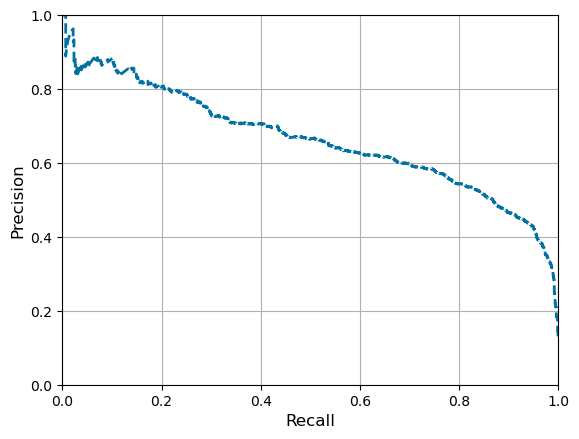

In [208]:
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [209]:
test = model_y_scores[:,1] > maxF1
defaultResults = fullPipe_RFC.predict(X_test)
TF_to_YesNoMap = {True:'yes', False:'no'}
testYN = np.vectorize(TF_to_YesNoMap.get)(test)

In [281]:
origPredictCM = confusion_matrix(y_test, defaultResults)
print(origPredictCM)
revenue, cost, profit, unRevenue = total_revenue(origPredictCM)
print("Revenue: ", revenue)
print("Cost: ", cost)
print("Profit: ", profit)
print("Unrealized Revenue: ", unRevenue)

[[7860 1234]
 [ 124 1076]]
Revenue:  86080
Cost:  36000
Profit:  50080
Unrealized Revenue:  98720


In [289]:
start_time = time.time()
revPredictCM = confusion_matrix(y_test, testYN)
print("--- %s seconds ---" % (time.time() - start_time))
print(revPredictCM)
revenue, cost, profit, unRevenue = total_revenue(revPredictCM)
print("Revenue: ", revenue)
print("Cost: ", cost)
print("Profit: ", profit)
print("Unrealized Revenue: ", unRevenue)

--- 0.03393983840942383 seconds ---
[[8249  845]
 [ 222  978]]
Revenue:  78240
Cost:  36000
Profit:  42240
Unrealized Revenue:  67600


This would take 3-4 minutes to execute across all thresholds, so we'll zoom into a smaller range. As it is, it will still take a minute.

In [290]:
#idxAry = np.where((thresholds >= .45) & (thresholds <= .75)) # zoomed, .45 to .75
idxAry = np.where((thresholds >= 0) & (thresholds <= 1)) #full scale
zoomAry = thresholds[idxAry[0]]
predictedCMAry = np.zeros((len(zoomAry), 2, 2), np.int16)
idx = 0
for threshold in zoomAry:
    resultsYN = get_new_predicted(threshold, model_y_scores)    #--- 0.000997781753540039 seconds ---
    revPredictCM = confusion_matrix(y_test, resultsYN) #--- 0.030942916870117188 seconds ---
    predictedCMAry[idx] = revPredictCM
    idx += 1

In [300]:
revenueAry = np.zeros(len(zoomAry), np.int32) # If we expected revenue and cost values to be decimal, this would have to change
costAry = np.zeros(len(zoomAry), np.int32)
profitAry = np.zeros(len(zoomAry), np.int32)
unRevenueAry = np.zeros(len(zoomAry), np.int32)
idx = 0
for cm in predictedCMAry:
    revenueAry[idx], costAry[idx], profitAry[idx], unRevenueAry[idx] = total_revenue(cm)
    idx += 1

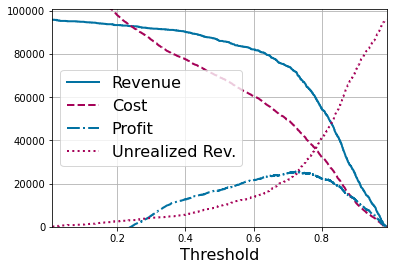

In [305]:
plot_rev_cost_vs_threshold(revenueAry, costAry, profitAry, unRevenueAry, zoomAry)
plt.show()

In [319]:
maxIdx = np.where(profitAry==profitAry.max())
print("Max profit is ", profitAry.max(), "at threshold = ", thresholds[maxIdx[0]][0])

Max profit is  25720 at threshold =  0.7266242145641421


In [306]:
revenueAry

array([95920, 95920, 95920, ...,   160,    80,     0])

In [307]:
costAry

array([269010, 268950, 268830, ...,     60,     30,      0])

In [308]:
profitAry

array([-173090, -173030, -172910, ...,     100,      50,       0])

In [311]:
profitAry.max()

25720

In [309]:
unRevenueAry

array([   80,    80,    80, ..., 95840, 95920, 96000])

In [310]:
predictedCMAry

array([[[1326, 7768],
        [   1, 1199]],

       [[1328, 7766],
        [   1, 1199]],

       [[1332, 7762],
        [   1, 1199]],

       ...,

       [[9094,    0],
        [1198,    2]],

       [[9094,    0],
        [1199,    1]],

       [[9094,    0],
        [1200,    0]]], dtype=int16)

### Balanced data sample?

In [288]:
y_test.value_counts()

no     9094
yes    1200
Name: y, dtype: int64

No, not very balanced. Might need to balance that when fitting the model

### Misc Functions

In [264]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    F1s = calc_F1_vector(precisions, recalls)
    maxF1 = np.amax(F1s)
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.plot(thresholds, F1s[:-1], "m-", label="F1", linewidth=2)
    plt.legend(loc="lower right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([thresholds.min(), thresholds.max(), 0, 1])             
    return maxF1

In [304]:
def plot_rev_cost_vs_threshold(revenue, cost, profit, unRevenue, thresholds):
    plt.plot(thresholds, revenue, "b-", label="Revenue", linewidth=2)
    plt.plot(thresholds, cost, "m--", label="Cost", linewidth=2)
    plt.plot(thresholds, profit, "b-.", label="Profit", linewidth=2)
    plt.plot(thresholds, unRevenue, "m:", label="Unrealized Rev.", linewidth=2)
    plt.legend(loc="center left", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([thresholds.min(), thresholds.max(), 0, revenue.max()*1.05])


In [159]:
def calc_F1_scalar(precision, recall):
    F1 = 2 * (precision * recall) / (precision + recall)
    return F1
calc_F1_vector = np.vectorize(calc_F1_scalar)

In [160]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls[:-1], precisions[:-1], "b--", linewidth=2)
    plt.xlabel("Recall", fontsize=12)
    plt.ylabel("Precision", fontsize=12)
    plt.grid(True)
    plt.axis([0, 1, 0, 1])

In [283]:
from matplotlib import pyplot as plt
import matplotlib
#matplotlib.style.use('ggplot')
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error, cohen_kappa_score, make_scorer
from sklearn.metrics import confusion_matrix, accuracy_score, average_precision_score
from sklearn.metrics import precision_recall_curve, SCORERS
from sklearn.model_selection import learning_curve

%matplotlib inline

mplUpdates = {'font.size':14.0,
              'axes.titlesize':'large',
              'axes.titleweight':'medium', 
              'axes.labelsize':'medium',
              'xtick.labelsize':'medium',
              'ytick.labelsize':'medium',
              'legend.fontsize':'small',
              'legend.title_fontsize': None}

def evaluate_model(model, class_labels, XinDF, yinDF):
    from yellowbrick.classifier import ROCAUC
    from yellowbrick.classifier import ConfusionMatrix
    from yellowbrick.classifier import ClassificationReport
    #yellowbrick.style.rcmod.set_aesthetic(palette='yellowbrick', font='sans-serif', font_scale=1.2, color_codes=True, rc=None)
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,5))
    
    model.fit(XinDF, yinDF)
    predictedDF = model.predict(XinDF)
    matplotlib.rc_context(rc=mplUpdates)
    
    # Some ROC settings requirements vary based on model type, so get that
    # sorted here.
    if 'SVC' in str(type(model.steps[1][1])):
        roc_per_class_Value = False
        rocBinaryValue = False
    if 'Forest' in str(type(model.steps[1][1])):
        roc_per_class_Value = True
        rocBinaryValue = False
        
    visualgrid = [
        ROCAUC(model, classes=class_labels, 
               macro=False, micro=False, per_class=roc_per_class_Value, binary = rocBinaryValue,
               ax=axes[0]),
        ClassificationReport(model, 
                             classes=class_labels,
                             cmap="Blues", ax=axes[1]),
        ConfusionMatrix(model, classes=class_labels, percent=True,
                        cmap="Blues", ax=axes[2])
    ]
    
    for viz in visualgrid:
        viz.fit(XinDF, yinDF)
        viz.score(XinDF, yinDF)
        viz.finalize()

    plt.show()
    matplotlib.rcdefaults()

In [299]:
'''
array([[7971,  461],
       [   0, 1862]], dtype=int64)
'''
def total_revenue(confMatrixAry):
    rev_per = gl_rev_per_encounter
    cost_per = gl_cost_per_encounter
    TN = confMatrixAry[0,0]
    FP = confMatrixAry[0,1]
    FN = confMatrixAry[1,0]
    TP = confMatrixAry[1,1]
    #print(TN, FN)
    #print(FP, TP)
    revenue = TP*rev_per
    cost = TP*cost_per + FP*cost_per
    profit = revenue - cost
    unRevenue = FN*rev_per
    return revenue, cost, profit, unRevenue


In [163]:
def get_new_predicted(threshold, y_scores):
    adjusted = y_scores[:,1] > threshold
    TF_to_YesNoMap = {True:'yes', False:'no'}
    adjustedYN = np.vectorize(TF_to_YesNoMap.get)(adjusted)
    return adjustedYN